In [1]:
from collections import OrderedDict
import gc
from pathlib import Path
import sys
sys.path.append('..')
from typing import Dict, List, Tuple, Union, Literal, Optional
import warnings
import joblib

import h5py
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

gc.enable()
print(torch.__version__)
print(torch.cuda.is_available())
# pytorch_tabnet version == 4.1.0 cannot use pytorch_tabnet.__version__ :(

2.3.0+cu121
True


In [2]:
KAGGLE = False
MODE:Literal['train', 'test'] = 'train'
FILL_NA = True
PRE_TRAIN = True

In [3]:
if KAGGLE:
    COMPETITION_DIR = Path('/kaggle/input/home-credit-credit-risk-model-stability')
    MODEL_DIR = Path('/kaggle/input/240407-home-credit-test-submit')
    FEATURE_DTYPE_DIR = Path('/kaggle/input/home-credit-enhanced-feature-definitions')
else:
    COMPETITION_DIR = Path('../../data/inputs')
    MODEL_DIR = Path('../../data/models/tabnet-pretrained-4fold')
    if not MODEL_DIR.exists():
        MODEL_DIR.mkdir(parents=True)
        MODEL_DIR.joinpath('encoders').mkdir()
        print(MODEL_DIR, 'created')
    FEATURE_DTYPE_DIR = Path('../../data/configs/feature_definitions_dtypes_tables.parquet')

In [4]:
df_features = pd.read_parquet(FEATURE_DTYPE_DIR)
display(df_features)

bool_features = df_features.query('dtype == "Boolean"')
float64_features = df_features.query('dtype == "Float64"')
string_features = df_features.query('dtype == "String"')
date_features = df_features.query('dtype == "Date"')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bool_features['cast_dtype'] = pl.Boolean
    float64_features['cast_dtype'] = pl.Float32
    string_features['cast_dtype'] = pl.String
    date_features['cast_dtype'] = pl.Date

cast_features = pd.concat([bool_features, float64_features, string_features, date_features], ignore_index=True)
display(cast_features)

,Variable,Description,dtype,tables
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...,Float64,"[train_applprev_1_0, train_applprev_1_1]"
1,actualdpdtolerance_344P,DPD of client with tolerance.,Float64,"[train_static_0_0, train_static_0_1]"
2,addres_district_368M,District of the person's address.,String,[train_person_2]
3,addres_role_871L,Role of person's address.,String,[train_person_2]
4,addres_zip_823M,Zip code of the address.,String,[train_person_2]
...,...,...,...,...
460,totinstallast1m_4525188A,Total amount of monthly instalments paid in th...,Float64,"[train_static_0_0, train_static_0_1]"
461,twobodfilling_608L,Type of application process.,String,"[train_static_0_0, train_static_0_1]"
462,type_25L,Contact type of a person.,String,[train_person_1]
463,typesuite_864L,Persons accompanying the client during the loa...,String,"[train_static_0_0, train_static_0_1]"


,Variable,Description,dtype,tables,cast_dtype
0,contaddr_matchlist_1032L,Indicates whether the contact address is found...,Boolean,[train_person_1],Boolean
1,contaddr_smempladdr_334L,Indicates whether the contact address is the s...,Boolean,[train_person_1],Boolean
2,equalitydataagreement_891L,Flag indicating sudden changes in client's soc...,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
3,equalityempfrom_62L,Flag indicating a sudden change in the client'...,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
4,isbidproduct_1095L,Flag indicating if the product is a cross-sell.,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
...,...,...,...,...,...
459,refreshdate_3813885D,Date when the credit bureau's public sources h...,Date,"[train_credit_bureau_a_1_0, train_credit_burea...",Date
460,responsedate_1012D,Tax authority's response date.,Date,[train_static_cb_0],Date
461,responsedate_4527233D,Tax authority's response date.,Date,[train_static_cb_0],Date
462,responsedate_4917613D,Tax authority's response date.,Date,[train_static_cb_0],Date


In [5]:
def get_depth_paths(load_dir: Path, prefix: Literal['test', 'train']):
    
    assert prefix in ['test', 'train']
    
    depth_paths = OrderedDict()

    depth_paths['static_0'] = []
    depth_paths['static_cb_0'] = []
    depth_paths['applprev_1'] = []
    depth_paths['other_1'] = []
    depth_paths['tax_registry_a_1'] = []
    depth_paths['tax_registry_b_1'] = []
    depth_paths['tax_registry_c_1'] = []
    depth_paths['credit_bureau_a_1'] = []
    depth_paths['credit_bureau_b_1'] = []
    depth_paths['deposit_1'] = []
    depth_paths['person_1'] = []
    depth_paths['debitcard_1'] = []
    depth_paths['applprev_2'] = []
    depth_paths['person_2'] = []
    depth_paths['credit_bureau_a_2'] = []
    depth_paths['credit_bureau_b_2'] = []

    for k in depth_paths.keys():
        depth_paths[k] = sorted(
            [p for p in load_dir.joinpath(f'parquet_files/{prefix}').glob(f'{prefix}_{k}*.parquet')]
        )
    return depth_paths

In [6]:
depth_paths = get_depth_paths(COMPETITION_DIR, MODE)

print(f'the number of {MODE} paths: {sum(len(v1) for v1 in depth_paths.values())}')

the number of train paths: 31


In [7]:
def process_D_features(data: pl.DataFrame, D_columns: List[str]):
    for col in D_columns:
        # 1. convert to datetime from string
        # 2. add y, m, d, wd columns
        # 3. delete original column
        data = data.with_columns([
            pl.col(col).str_to_datetime(format='%Y-%m-%d', errors='coerce').alias(col)
        ])
        data = data.with_columns([
            pl.col(col).year().alias(f'y_{col}'),
            pl.col(col).month().alias(f'm_{col}'),
            pl.col(col).day().alias(f'd_{col}'),
            pl.col(col).weekday().alias(f'wd_{col}')
        ])
        data.drop_in_place(col)
    return data

def process_date_features(data: pl.DataFrame) -> pl.DataFrame:
    data = data.with_columns(
        pl.col(pl.Date).dt.year().cast(pl.Float32).name.prefix('year_'),
        pl.col(pl.Date).dt.month().cast(pl.Float32).name.prefix('month_'),
        pl.col(pl.Date).dt.day().cast(pl.Float32).name.prefix('day_'),
    )
    data = data.drop(cs.date())
    return data

In [8]:
def merge_dataset(
        base_data: pl.DataFrame,
        depth_paths: Dict[str, List[Path]],
        bool_features: pd.DataFrame,
        float64_features: pd.DataFrame,
        string_features: pd.DataFrame,
        depth: Literal['0', '1', '2', '012'],
    ) -> pd.DataFrame:
    
    assert depth in ['0', '1', '2', '012']
    
    for i, (k, path_list) in enumerate(depth_paths.items()):
        
        if depth == '012':
            pass
        elif depth != k[-1]:
            continue
            
        print(f'loading `{k}`')
        depth_data = []
        for p in path_list:
            sub_data = pl.read_parquet(p).cast({'case_id': pl.Int64})
            if k[-1] == '1':
                sub_data = sub_data.drop('num_group1').group_by('case_id').max().sort('case_id')
            elif k[-1] == '2':
                sub_data = sub_data.drop(['num_group1', 'num_group2']).group_by('case_id').max().sort('case_id')
                
            depth_data.append(sub_data)
            
            print(f'\t{p.stem}: {sub_data.shape}')
            
            del sub_data
            gc.collect()
        
        depth_data = pl.concat(depth_data, how='vertical_relaxed')
        base_data = base_data.join(depth_data, how='left', on='case_id', suffix=f'_{i}')
        
        del depth_data
        gc.collect()
    
    '''
    cast dtypes
    '''
    for _, row in bool_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).fill_null(np.nan).cast(cast_dtype))
        
    for _, row in float64_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).cast(cast_dtype))
            
    for _, row in string_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).cast(cast_dtype))
    
    '''
    process D features
    '''
    D_features = [col for col in base_data.columns if col[-1] == 'D']
    # base_data = process_D_features(base_data, D_features)
    base_data = process_date_features(base_data)
    base_data = base_data.to_pandas()
    return base_data


def encode(depth_data:pd.DataFrame, mode:Literal['train', 'test'], save_dir:Path) -> pd.DataFrame:

    assert mode in ['train', 'test']

    object_columns = depth_data.dtypes.index[depth_data.dtypes==object].to_list()
    if 'date_decision' in object_columns:
        object_columns.remove('date_decision')

    if mode == 'train':
        object_data = []
        print(f'num of object columns: {len(object_columns)}')
        for col in object_columns:
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            encoder.fit(depth_data[col].values.reshape(-1, 1))
            # save encoder as joblib
            save_path = save_dir.joinpath(f'encoder_{col}.joblib')
            joblib.dump(encoder, save_path)
            object_data.append(encoder.transform(depth_data[col].values.reshape(-1, 1)).astype(np.float32))
        depth_data.drop(columns=object_columns, inplace=True)
        print(f'num of object columns: {len(object_data)}')
        object_data = np.concatenate(object_data, axis=1)
        object_data = pd.DataFrame(object_data, columns=object_columns)
    else:
        object_data = []
        for col in object_columns:
            # load encoder
            load_path = save_dir.joinpath(f'encoder_{col}.joblib')
            encoder = joblib.load(load_path)
            object_data.append(encoder.transform(depth_data[col].values.reshape(-1, 1)).astype(np.float32))
        depth_data.drop(columns=object_columns, inplace=True)
        object_data = np.concatenate(object_data, axis=1)
        object_data = pd.DataFrame(object_data, columns=object_columns)

    return pd.concat([depth_data, object_data], axis=1)


In [9]:
base_data = pl.read_parquet(
    COMPETITION_DIR.joinpath(f'parquet_files/{MODE}/{MODE}_base.parquet')
).cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
    }
)

print(MODE)
display(base_data)

train


case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0
2703451,"""2020-10-05""",202010,91,0
2703452,"""2020-10-05""",202010,91,0


In [10]:
depth_data = merge_dataset(
    base_data,
    depth_paths,
    bool_features,
    float64_features,
    string_features,
    '012'
)
display(depth_data)

loading `static_0`
	train_static_0_0: (1003757, 168)
	train_static_0_1: (522902, 168)
loading `static_cb_0`
	train_static_cb_0: (1500476, 53)
loading `applprev_1`
	train_applprev_1_0: (782997, 40)
	train_applprev_1_1: (438525, 40)
loading `other_1`
	train_other_1: (51109, 6)
loading `tax_registry_a_1`
	train_tax_registry_a_1: (457934, 4)
loading `tax_registry_b_1`
	train_tax_registry_b_1: (150732, 4)
loading `tax_registry_c_1`
	train_tax_registry_c_1: (482265, 4)
loading `credit_bureau_a_1`
	train_credit_bureau_a_1_0: (335275, 78)
	train_credit_bureau_a_1_1: (549263, 78)
	train_credit_bureau_a_1_2: (325127, 78)
	train_credit_bureau_a_1_3: (176608, 78)
loading `credit_bureau_b_1`
	train_credit_bureau_b_1: (36500, 44)
loading `deposit_1`
	train_deposit_1: (105111, 4)
loading `person_1`
	train_person_1: (1526659, 36)
loading `debitcard_1`
	train_debitcard_1: (111772, 5)
loading `applprev_2`
	train_applprev_2: (1221522, 4)
loading `person_2`
	train_person_2: (1435105, 9)
loading `credit_bu

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,12.0,0.00000,4316.439941,2021.0,2021.0,ab3c25cf,ab3c25cf,None,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,12.0,0.00000,0.000000,2021.0,2021.0,ab3c25cf,ab3c25cf,None,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,12.0,4884.29834,0.000000,2021.0,2020.0,ab3c25cf,ab3c25cf,None,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,12.0,0.00000,2693.199951,2021.0,2020.0,ab3c25cf,ab3c25cf,None,NaN,NaN


In [11]:
depth_data = encode(depth_data, MODE, MODEL_DIR.joinpath('encoders'))
display(depth_data)

num of object columns: 156
num of object columns: 156


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,empls_employedfrom_796D,empls_employer_name_740M,relatedpersons_role_762T,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,subjectroles_name_541M,subjectroles_name_838M,pmts_date_1107D
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,801.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0,27.0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,801.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0,27.0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,801.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0,27.0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,801.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0,27.0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,801.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,801.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0,27.0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,801.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0,27.0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,801.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0,27.0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,801.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0,27.0


In [12]:
if MODE == 'train':
    X, y= (
        depth_data.drop(columns=['case_id', 'target', 'date_decision']),
        depth_data[['case_id', 'target', 'WEEK_NUM']],
    )
else:
    X = depth_data.drop(columns=['case_id', 'date_decision'])
    y = depth_data[['case_id', 'WEEK_NUM']]

In [13]:
X.dtypes.value_counts()

float32    451
bool        13
int64        2
Name: count, dtype: int64

In [14]:
if FILL_NA:
    X.fillna(-999, inplace=True)
    assert X.isnull().sum().sum() == 0

In [15]:
# if MODE == 'train':
#     with h5py.File(MODEL_DIR.joinpath(f'processed_data.h5'), 'w') as f:
#         f.create_dataset('X', data=X.values.astype(np.float32))
    
#     y.to_hdf(MODEL_DIR.joinpath(f'processed_data.h5'), key='y', mode='w')
# else:
#     pass

In [16]:
params = dict(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    device_name='auto',
)

In [5]:
def pre_train(X: pd.DataFrame, params: dict):
    X_train, X_valid = train_test_split(X, test_size=0.1, random_state=42)
    pretrainer = TabNetPretrainer(
        **params
    )

    X_train = X_train.values.astype(np.float32)
    X_valid = X_valid.values.astype(np.float32)

    gc.collect()
    
    pretrainer.fit(
        X_train=X_train,
        eval_set=[X_train, X_valid],
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        pretraining_ratio=0.8,
    )

    # save pretrainer
    pretrain_path = MODEL_DIR.joinpath('pretrainer')
    pretrainer.save_model(str(pretrain_path))

    gc.collect()
    
    return pretrainer

def train(
        X:pd.DataFrame, y:pd.DataFrame, params:dict,
        pretrainer:Optional[TabNetPretrainer]=None, fold_resume:Optional[int]=None
        ):
    n_splits = 4
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y['target'], y['WEEK_NUM'])):
        if (fold_resume is not None) and (fold < fold_resume):
            continue
        print(f'fold: {fold}')
        X_train = X.iloc[train_idx].values.astype(np.float32)
        X_valid = X.iloc[valid_idx].values.astype(np.float32)

        y_train = y.loc[train_idx, 'target'].values
        y_valid = y.loc[valid_idx, 'target'].values


        print(X_train.shape, y_train.shape)
        print(X_train.dtype, y_train.dtype)

        model = TabNetClassifier(**params)
        model.fit(
            X_train=X_train,
            y_train=y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_name=['train', 'valid'],
            eval_metric=['accuracy', 'balanced_accuracy', 'logloss'],
            max_epochs=100,
            patience=10,
            batch_size=512,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            from_unsupervised=pretrainer
        )
        print('end training')

        models.append(model)
        y_pred = model.predict_proba(X_valid)
        print('end predict')
        # save oof
        np.save(MODEL_DIR.joinpath(f'oof_{fold}'), np.stack([valid_idx, y_pred[:, 1]], axis=1))

        model_path = MODEL_DIR.joinpath(f'model_{fold}')
        model.save_model(str(model_path))
        print(f'model saved: {model_path}')

        del X_train, X_valid, y_train, y_valid, model, y_pred

        gc.collect()

    return models

def evaluate(y:pd.DataFrame):
    from scripts import data
    evaluator = data.Evaluator(y, y['score'], save_path=MODEL_DIR)

    evaluator.plot_pred(is_log=True)
    evaluator.plot_roc()
    df_gini_weeks, stability = evaluator.plot_gini()
    return df_gini_weeks, stability

In [18]:
if MODE == 'train':
    # pretrainer = pre_train(X, params) if PRE_TRAIN else None
    pretrainer = TabNetPretrainer().load_model(str(MODEL_DIR.joinpath('pretrainer.zip')))
    models = train(X, y, params, pretrainer)
else:
    pass

/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


fold: 0
(1071381, 466) (1071381,)
float32 int64


/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.13118 | train_accuracy: 0.96914 | train_balanced_accuracy: 0.5     | train_logloss: 0.12263 | valid_accuracy: 0.96721 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12836 |  0:02:33s
epoch 1  | loss: 0.11966 | train_accuracy: 0.96914 | train_balanced_accuracy: 0.5     | train_logloss: 0.1202  | valid_accuracy: 0.96721 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12609 |  0:05:03s
epoch 2  | loss: 0.11802 | train_accuracy: 0.96914 | train_balanced_accuracy: 0.5     | train_logloss: 0.1176  | valid_accuracy: 0.96721 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12353 |  0:07:31s
epoch 3  | loss: 0.11648 | train_accuracy: 0.96914 | train_balanced_accuracy: 0.5     | train_logloss: 0.11791 | valid_accuracy: 0.96721 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12397 |  0:09:57s
epoch 4  | loss: 0.11602 | train_accuracy: 0.96914 | train_balanced_accuracy: 0.5     | train_logloss: 0.1157  | valid_accuracy: 0.96721 | valid_balanced_accuracy: 

/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


end training
end predict
Successfully saved model at ../../data/models/tabnet-pretrained-4fold/model_0.zip
model saved: ../../data/models/tabnet-pretrained-4fold/model_0
fold: 1
(1153679, 466) (1153679,)
float32 int64


/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.13551 | train_accuracy: 0.96902 | train_balanced_accuracy: 0.5     | train_logloss: 0.1263  | valid_accuracy: 0.96716 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.1327  |  0:02:18s
epoch 1  | loss: 0.12373 | train_accuracy: 0.96902 | train_balanced_accuracy: 0.5     | train_logloss: 0.12012 | valid_accuracy: 0.96716 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.1265  |  0:04:32s
epoch 2  | loss: 0.11965 | train_accuracy: 0.96902 | train_balanced_accuracy: 0.5     | train_logloss: 0.12018 | valid_accuracy: 0.96716 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12695 |  0:06:48s
epoch 3  | loss: 0.11829 | train_accuracy: 0.96902 | train_balanced_accuracy: 0.5     | train_logloss: 0.11746 | valid_accuracy: 0.96715 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12387 |  0:09:03s
epoch 4  | loss: 0.11718 | train_accuracy: 0.96902 | train_balanced_accuracy: 0.5     | train_logloss: 0.11768 | valid_accuracy: 0.96715 | valid_balanced_accuracy: 

/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


end training
end predict
Successfully saved model at ../../data/models/tabnet-pretrained-4fold/model_1.zip
model saved: ../../data/models/tabnet-pretrained-4fold/model_1
fold: 2
(1148575, 466) (1148575,)
float32 int64


/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.13445 | train_accuracy: 0.96817 | train_balanced_accuracy: 0.5     | train_logloss: 0.12659 | valid_accuracy: 0.96977 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12215 |  0:02:18s
epoch 1  | loss: 0.12322 | train_accuracy: 0.96816 | train_balanced_accuracy: 0.5     | train_logloss: 0.12417 | valid_accuracy: 0.96976 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.12026 |  0:04:36s
epoch 2  | loss: 0.12078 | train_accuracy: 0.96817 | train_balanced_accuracy: 0.5     | train_logloss: 0.12132 | valid_accuracy: 0.96977 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.11908 |  0:06:54s
epoch 3  | loss: 0.11973 | train_accuracy: 0.96817 | train_balanced_accuracy: 0.5     | train_logloss: 0.11973 | valid_accuracy: 0.96977 | valid_balanced_accuracy: 0.5     | valid_logloss: 0.11756 |  0:09:10s
epoch 4  | loss: 0.11904 | train_accuracy: 0.96817 | train_balanced_accuracy: 0.5     | train_logloss: 0.12051 | valid_accuracy: 0.96977 | valid_balanced_accuracy: 

/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


end training
end predict
Successfully saved model at ../../data/models/tabnet-pretrained-4fold/model_2.zip
model saved: ../../data/models/tabnet-pretrained-4fold/model_2
fold: 3
(1206342, 466) (1206342,)
float32 int64


/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.13588 | train_accuracy: 0.968   | train_balanced_accuracy: 0.5     | train_logloss: 0.12694 | valid_accuracy: 0.9707  | valid_balanced_accuracy: 0.5     | valid_logloss: 0.11823 |  0:02:22s
epoch 1  | loss: 0.12439 | train_accuracy: 0.968   | train_balanced_accuracy: 0.5     | train_logloss: 0.12227 | valid_accuracy: 0.9707  | valid_balanced_accuracy: 0.5     | valid_logloss: 0.11445 |  0:04:44s
epoch 2  | loss: 0.12162 | train_accuracy: 0.968   | train_balanced_accuracy: 0.5     | train_logloss: 0.12166 | valid_accuracy: 0.9707  | valid_balanced_accuracy: 0.5     | valid_logloss: 0.11336 |  0:07:05s
epoch 3  | loss: 0.12055 | train_accuracy: 0.96799 | train_balanced_accuracy: 0.5     | train_logloss: 0.11989 | valid_accuracy: 0.9707  | valid_balanced_accuracy: 0.5     | valid_logloss: 0.11214 |  0:09:27s
epoch 4  | loss: 0.11955 | train_accuracy: 0.968   | train_balanced_accuracy: 0.5     | train_logloss: 0.12025 | valid_accuracy: 0.9707  | valid_balanced_accuracy: 

/home/oxyut/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


end training
end predict
Successfully saved model at ../../data/models/tabnet-pretrained-4fold/model_3.zip
model saved: ../../data/models/tabnet-pretrained-4fold/model_3


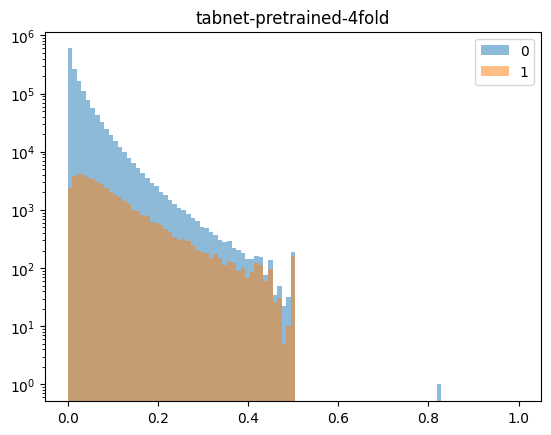

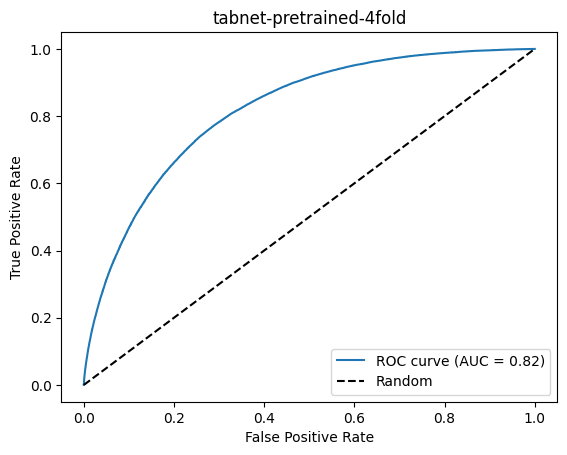

0.6124679592670416


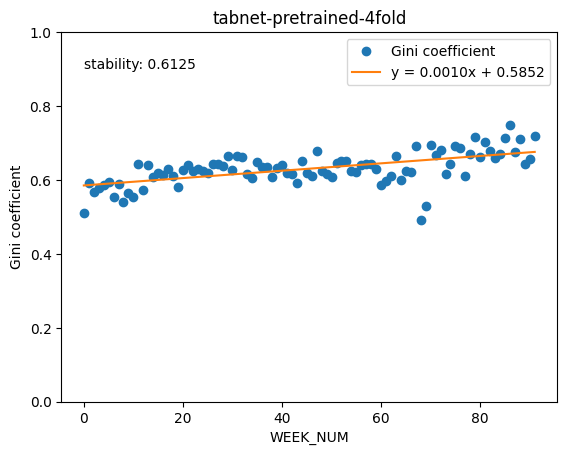

,WEEK_NUM,Gini
0,0,0.511838
1,1,0.591158
2,2,0.567010
3,3,0.577957
4,4,0.585761
...,...,...
87,87,0.675643
88,88,0.711554
89,89,0.644109
90,90,0.655462


0.6124679592670416

In [6]:
# evaluate oof
oof = []
for fold in range(4):
    oof.append(np.load(MODEL_DIR.joinpath(f'oof_{fold}.npy')))

oof = np.concatenate(oof, axis=0)
df_oof = pd.DataFrame(oof, columns=['index', 'score'])
df_oof['index'] = df_oof['index'].astype(np.int64)
df_oof = df_oof.sort_values('index').reset_index(drop=True).drop(columns='index')


df_base = pl.read_parquet(
    COMPETITION_DIR.joinpath(f'parquet_files/{MODE}/{MODE}_base.parquet')
).to_pandas()

# merge oof and base with index
df_oof = pd.concat([df_base, df_oof], axis=1)

df_gini_weeks, stability = evaluate(df_oof)
display(df_gini_weeks)
display(stability)

In [35]:
df_oof

,case_id,date_decision,MONTH,WEEK_NUM,target,score
0,0,2019-01-03,201901,0,0,0.059800
1,1,2019-01-03,201901,0,0,0.025540
2,2,2019-01-04,201901,0,0,0.081238
3,3,2019-01-03,201901,0,0,0.096263
4,4,2019-01-04,201901,0,1,0.112700
...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.001279
1526655,2703451,2020-10-05,202010,91,0,0.002607
1526656,2703452,2020-10-05,202010,91,0,0.160198
1526657,2703453,2020-10-05,202010,91,0,0.000805
